In [1]:
import cv2
import numpy as np

import torch

import openvino as ov

In [2]:
pt_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in C:\Users\yas_s/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-3-28 Python-3.11.1 torch-2.2.2+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [4]:
example_input = torch.Tensor(size=(1,3,640,640))
pt_model(example_input)
ov_model = ov.convert_model(pt_model, example_input=example_input)
ov_model

C:\Users\yas_s/.cache\torch\hub\ultralytics_yolov5_master\models\yolo.py:100: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.dynamic or self.grid[i].shape[2:4] != x[i].shape[2:4]:
C:\Users\yas_s/.cache\torch\hub\ultralytics_yolov5_master\models\yolo.py:100: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.dynamic or self.grid[i].shape[2:4] != x[i].shape[2:4]:


<Model: 'Model2'
inputs[
<ConstOutput: names[ims, 16, 17, im] shape[?,?,?,?] type: f32>
]
outputs[
<ConstOutput: names[] shape[?,?,85] type: f32>
]>

In [5]:
#ov_model.reshape((1,3,640,640))
#print(ov_model)
compiled_model = ov.compile_model(ov_model, device_name='CPU')
compiled_model

<CompiledModel:
inputs[
<ConstOutput: names[ims, 16, 17, im] shape[?,?,?,?] type: f32>
]
outputs[
<ConstOutput: names[] shape[?,25200,85] type: f32>
]>

In [6]:
img = cv2.imread('cars.jpg')
print(img.shape)
img = cv2.resize(img, (640, 640))
reshaped_img = img.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)   # BGR -> RGB
img = np.transpose(img, (2, 0, 1))      # HWC -> CHW  (h,w,c) -> (c,h,w)
img = np.expand_dims(img, axis=0)       # CHW -> NCHW (c,h,w) -> (1,c,h,w)
img = img / 255
print(img.shape)

(3456, 5184, 3)
(1, 3, 640, 640)


In [7]:
res = compiled_model.infer_new_request(img)
res[0].shape

(1, 25200, 85)

### Postprocessing
[back to top ⬆️](#Table-of-contents:)

Model output contains detection boxes candidates. It is a tensor with the `[1,25200,85]` shape in the `B, N, 85` format, where:

- `B` - batch size
- `N` - number of detection boxes

Detection box has the [`x`, `y`, `h`, `w`, `box_score`, `class_no_1`, ..., `class_no_80`] format, where:

- (`x`, `y`) - raw coordinates of box center
- `h`, `w` - raw height and width of box
- `box_score` - confidence of detection box
- `class_no_1`, ..., `class_no_80` - probability distribution over the classes.

For getting final prediction, we need to apply non maximum suppression algorithm and rescale boxes coordinates to original image size.

In [8]:
def calc_iou(box0, box1):
    b0_x0, b0_y0, b0_x1, b0_y1 = box0
    b1_x0, b1_y0, b1_x1, b1_y1 = box1
    b0_area = (b0_x1 - b0_x0) * (b0_y1 - b0_y0)
    b1_area = (b1_x1 - b1_x0) * (b1_y1 - b1_y0)
    xx0 = max(b0_x0, b1_x0)
    yy0 = max(b0_y0, b1_y0)
    xx1 = min(b0_x1, b1_x1)
    yy1 = min(b0_y1, b1_y1)
    w = max(0, xx1 - xx0)
    h = max(0, yy1 - yy0)
    intersect = w * h
    union = (b0_area + b1_area - intersect)
    iou = intersect / union
    return iou

def nms(predicts, iou_threshold=0.5):
    # predicts = x0, y0, x1, y1, score, *classes[80]
    predicts = predicts[np.argsort(predicts[:,4])]   # sort by score
    res = []
    while(len(predicts)>0):
        res.append(predicts[0])
        box0 = predicts[0][:4]
        remove_indices = [0]
        # Reject largely overlapping bboxes by calculating IOU (intersection over union)
        for idx in range(1, len(predicts)):
            box1 = predicts[idx][:4]
            iou = calc_iou(box0, box1)
            if iou > iou_threshold:
                remove_indices.append(idx)
        for idx in remove_indices[::-1]:  # Remove the overlapping bbox in the reverse order
            predicts = np.delete(predicts, idx, axis=0)
    return res

In [9]:
coco_class_label = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 
                    'fire hydrant', 'stop sign','parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 
                    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
                    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 
                    'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 
                    'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 
                    'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 
                    'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

pascal_voc_class_label = ['Person', 'Car', 'Bicycle', 'Bus', 'Motorbike', 'Train', 'Aeroplane', 'Chair', 'Bottle', 'Dining Table', 'Potted Plant', 
                          'TV/Monitor', 'Sofa', 'Bird', 'Cat', 'Cow', 'Dog', 'Horse', 'Sheep' ]


In [10]:
predicts = res[0][0]    # (25200, 85)
print(predicts.shape[0])

score_limit = 0.65

# screen out low score items
predicts = np.array([predict for predict in predicts if predict[4]>score_limit])
print(predicts.shape[0])

# predicts = x, y, h, w, score, *classes[80]
x = predicts[:, 0].copy()
y = predicts[:, 1].copy()
h = predicts[:, 2].copy()
w = predicts[:, 3].copy()
predicts[:, 0] = x - h/2
predicts[:, 1] = y - w/2
predicts[:, 2] = x + h/2
predicts[:, 3] = y + w/2
# predicts = x0, y0, x1, y1, score, *classes[80]

# NMS : Non Maximum Suppression
nms_result = nms(predicts, 0.7)
print(len(nms_result))

25200
246
26


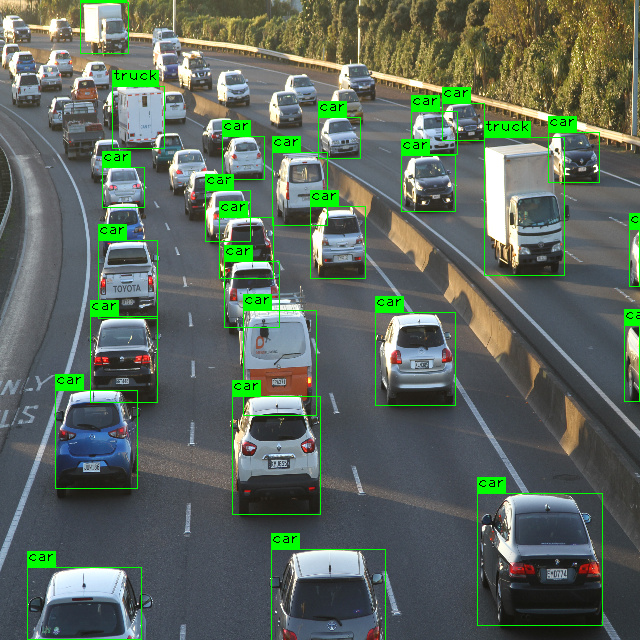

In [11]:
img_w, img_h, _ = reshaped_img.shape
out_img = reshaped_img.copy()
for bbox in nms_result:
    x0, y0, x1, y1 = bbox[:4].astype(np.int32)
    box_score = bbox[4]
    if box_score > score_limit:
        # Draw BBox
        cv2.rectangle(out_img, (x0, y0), (x1, y1), (0, 255, 0), thickness=1)
        # Draw class label
        class_id = np.argmax(bbox[5:])
        text = coco_class_label[class_id]
        (w, h), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_PLAIN, fontScale=1, thickness=1)
        cv2.rectangle(out_img, (x0, y0), (x0 + w, y0 - h - baseline), color=(0,255,0), thickness=-1)
        cv2.putText(out_img, text, (x0, y0 - baseline), cv2.FONT_HERSHEY_PLAIN, fontScale=1, color=(0,0,0), thickness=1)

from PIL import Image
from IPython.display import display
out_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
pil_img = Image.fromarray(out_img)
display(pil_img)